In [43]:
"""
Requirements
pip install scipy==1.9.3 scanpy igraph harmonypy 
"""
import os

from anndata import AnnData

import scanpy as sc
import scipy.stats as ss
import pandas as pd
import harmonypy as hm

# Define Filenames
H5_FILENAME = 'GSE178341_crc10x_full_c295v4_submit.h5'
H5AD_FILENAME = H5_FILENAME.replace('.h5', '.h5ad')

CYTOTRACE_OUTFILE = 'cytotrace_input_normalized.csv'

QC_FILENAME = 'GSE178341_QC.h5ad'

CLUSTER_FILENAME = 'GSE178341_crc10x_full_c295v4_submit_cluster.csv'
METADATA_FILENAME = 'GSE178341_crc10x_full_c295v4_submit_metatables.csv'



In [ ]:
# Convert h5 to h5AD (Roughly 10 minutes)
if not os.path.exists(H5AD_FILENAME) and os.path.exists(H5_FILENAME):
    adata = sc.read_10x_h5(H5_FILENAME)
    adata.write_h5ad(H5AD_FILENAME)

In [ ]:
# Read h5AD File 
adata = sc.read_h5ad(H5AD_FILENAME)

In [ ]:
# Create Gene Expression Table to Upload into CytoTRACE (Roughly 13 minutes)
if not os.path.exists(CYTOTRACE_OUTFILE):
    # Convert Sparse to Dense Matrix
    dense_matrix = adata.X.toarray()

    # Create DataFrame
    df = pd.DataFrame(
        dense_matrix.T,  # Transpose Matrix to get into following format: [genes x cells]
        index=adata.var_names,  
        columns=adata.obs_names
    )

    # Export to CSV
    df.to_csv(CYTOTRACE_OUTFILE)

In [ ]:
# Identify mitochondrial genes (assuming human dataset with 'MT-' prefix)
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Compute QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# View QC metrics
print(adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt"]].head())

In [ ]:
# Define QC thresholds
min_genes = 200  # Cells must have at least 200 genes
max_genes = 5000  # Remove cells with very high gene counts
max_mt = 5  # Remove cells with >5% mitochondrial RNA

# Apply filtering
adata = adata[adata.obs.n_genes_by_counts > min_genes, :]
adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
adata = adata[adata.obs.pct_counts_mt < max_mt, :]

print(f"Remaining cells after filtering: {adata.n_obs}")

In [ ]:
# Filter Out Low-Quality Genes
sc.pp.filter_genes(adata, min_cells=3)  # Keep genes present in at least 3 cells

In [ ]:
# Normalize & Log-Transform Data for downstream analysis
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Identify Highly Variable Genes
# Select genes that show high variability across cells
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

print(f"Number of highly variable genes: {adata.shape[1]}")

In [ ]:
# Save the Processed Data
adata.write(QC_FILENAME)

In [2]:
"""
* * * * * * *
 START HERE!
* * * * * * *
"""
adata = sc.read_h5ad(QC_FILENAME)

In [4]:
# Format data for Batch Correction
"""
FORMAT obs_names = C[PatientID]_[Region]_[X]_[Y]_[Z]_c[Cluster]_v[Version]_[Barcode]
T, N, TA, TB → Sample Type / Region
    T → Tumor sample
    N → Normal (adjacent) tissue
    TA, TB → Multiple tumor regions (possibly from different sections of the same tumor or replicates from the same patient)
"""
obs_names = adata.obs_names.str.split('_')
adata.obs["batch"] = obs_names.str[0]     # Patient IDs
adata.obs["region"] = obs_names.str[1]    # Sample Regions ()
print(adata.obs["batch"].value_counts())  # Number of cells per patient sample
print(adata.obs["region"].value_counts())

batch
C129    6895
C126    6013
C132    5579
C124    5026
C130    4283
        ... 
C168      90
C160      86
C172      83
C173      75
C161      33
Name: count, Length: 62, dtype: int64
region
T     61539
N     28852
TA     2960
TB     1942
Name: count, dtype: int64


In [ ]:
def merge_csv(adata: AnnData, csv_filename: str, index_column: str, merge_column: str):
    # Prevent redundant merging
    if merge_column in adata.obs.columns:
        return

    # Read the CSV, extracting only the necessary columns
    csv = pd.read_csv(csv_filename)[[index_column, merge_column]]
    
    # Merge in the cluster information by matching the cell IDs
    adata.obs = adata.obs.reset_index()
    adata.obs = adata.obs.merge(csv, left_on='index', right_on=index_column, how='left')
    adata.obs = adata.obs.set_index('index')

    # Clean up duplicate column after merge
    adata.obs.drop(columns=[index_column], inplace=True)

In [51]:
# Read metadata
merge_csv(adata, METADATA_FILENAME, 'cellID', 'MMRStatus')

# Read cell type
merge_csv(adata, CLUSTER_FILENAME, 'sampleID', 'clTopLevel')
merge_csv(adata, CLUSTER_FILENAME, 'sampleID', 'clMidwayPr')


In [ ]:
# Subset immune cells
immune_categories = ['TNKILC', 'Myeloid', 'B', 'Mast', 'Plasma']
adata = adata[adata.obs['clTopLevel'].isin(immune_categories)].copy()
adata.obs['clTopLevel'].value_counts()

clTopLevel
TNKILC     27736
Plasma     26605
Myeloid    13133
B           7925
Mast        1459
Name: count, dtype: int64

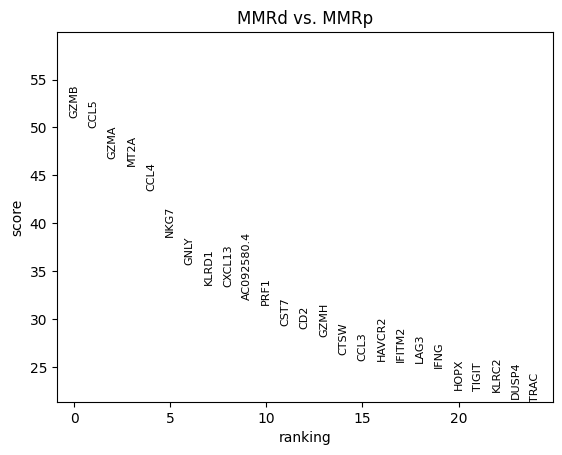

In [39]:
# Run Differential Expression
sc.tl.rank_genes_groups(adata, groupby='MMRStatus', groups=['MMRd'], reference='MMRp', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [22]:
# Separate dataset into MMRp and MMRd
adata_MMRp = adata[adata.obs['MMRStatus'] == 'MMRp'].copy()
adata_MMRd = adata[adata.obs['MMRStatus'] == 'MMRd'].copy()

In [48]:
# Relative Abundance Analysis
mmrd_counts = adata_MMRd.obs['clTopLevel'].value_counts(normalize=True) * 100
mmrp_counts = adata_MMRp.obs['clTopLevel'].value_counts(normalize=True) * 100

abundance_df = pd.DataFrame({
    'MMRp (%)': mmrp_counts,
    'MMRd (%)': mmrd_counts,
}, index=adata.obs['clTopLevel'].unique())

display(abundance_df)

# Confirm Significance of Relative Abundance with Chi-Square Test
chi2, p, dof, expected = ss.chi2_contingency(abundance_df)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

,MMRp (%),MMRd (%)
Myeloid,23.165547,23.709001
Plasma,25.356604,13.685022
Mast,2.448224,1.357369
TNKILC,37.714305,55.215381
B,11.315320,6.033228


Chi-square statistic: 8.712374760159877
P-value: 0.06870488556599738


In [ ]:
# Perform PCA and clustering
# For MMRp
sc.tl.pca(adata_MMRp, svd_solver='arpack')
sc.pp.neighbors(adata_MMRp, n_neighbors=10, n_pcs=40)

# For MMRd
sc.tl.pca(adata_MMRd, svd_solver='arpack')
sc.pp.neighbors(adata_MMRd, n_neighbors=10, n_pcs=40)

In [ ]:
# Run Harmony for batch correction (2 minutes)
adata_MMRp.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRp.obsm["X_pca"], adata_MMRp.obs, 'batch').Z_corr.T # transpose result to fit expected shape
adata_MMRd.obsm["X_pca_harmony"] = hm.run_harmony(adata_MMRd.obsm["X_pca"], adata_MMRd.obs, 'batch').Z_corr.T

2025-03-12 22:36:17,476 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-12 22:36:28,731 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-12 22:36:28,999 - harmonypy - INFO - Iteration 1 of 10
2025-03-12 22:36:44,262 - harmonypy - INFO - Iteration 2 of 10
2025-03-12 22:37:01,483 - harmonypy - INFO - Iteration 3 of 10
2025-03-12 22:37:17,846 - harmonypy - INFO - Converged after 3 iterations
2025-03-12 22:37:17,932 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-12 22:37:27,438 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-12 22:37:27,667 - harmonypy - INFO - Iteration 1 of 10
2025-03-12 22:37:38,850 - harmonypy - INFO - Iteration 2 of 10
2025-03-12 22:37:49,688 - harmonypy - INFO - Iteration 3 of 10
2025-03-12 22:38:00,884 - harmonypy - INFO - Iteration 4 of 10
2025-03-12 22:38:11,797 - harmonypy - INFO - Iteration 5 of 10
2025-03-12 22:38:16,822 - harmonypy - INFO - Converged after

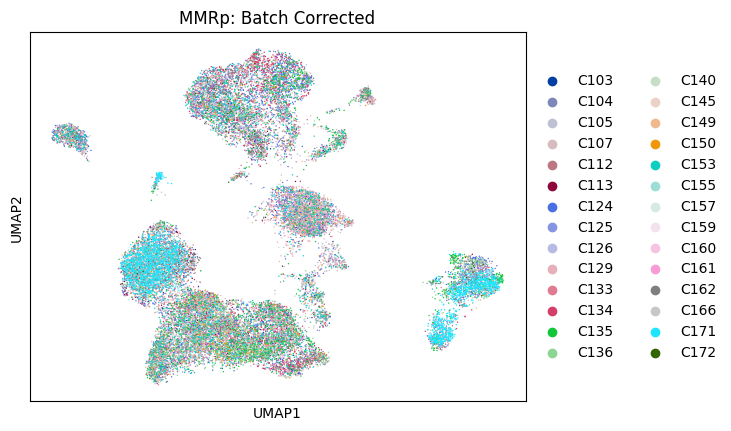

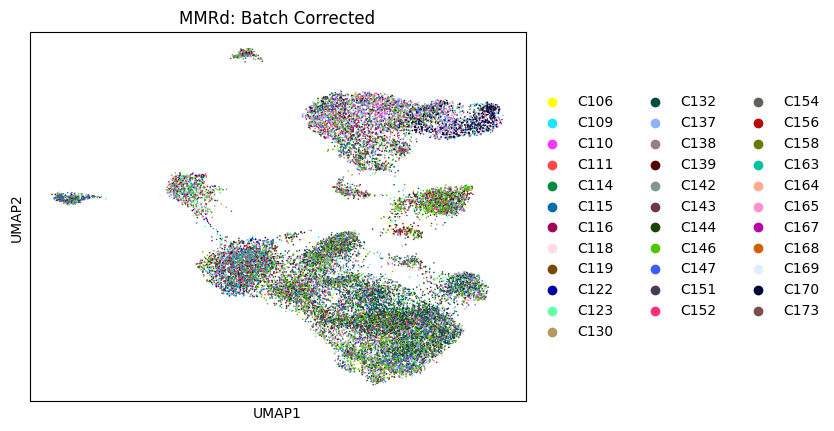

In [ ]:
# Update neighbors & recompute UMAP (1.25 minutes)
sc.pp.neighbors(adata_MMRp, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRp)
sc.pl.umap(adata_MMRp, color="batch", title="MMRp: Batch Corrected")

sc.pp.neighbors(adata_MMRd, use_rep="X_pca_harmony")
sc.tl.umap(adata_MMRd)
sc.pl.umap(adata_MMRd, color="batch", title="MMRd: Batch Corrected")

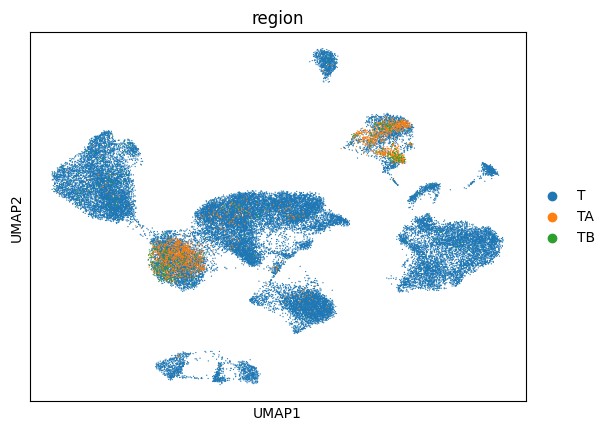

In [12]:
# Verify Teal Cluster is due to Biological Variation not Leftover Batch Effects
sc.pl.umap(adata_MMRp, color=['region'])

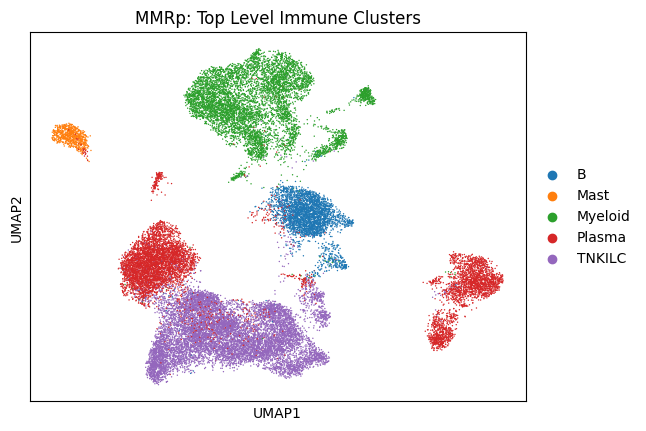

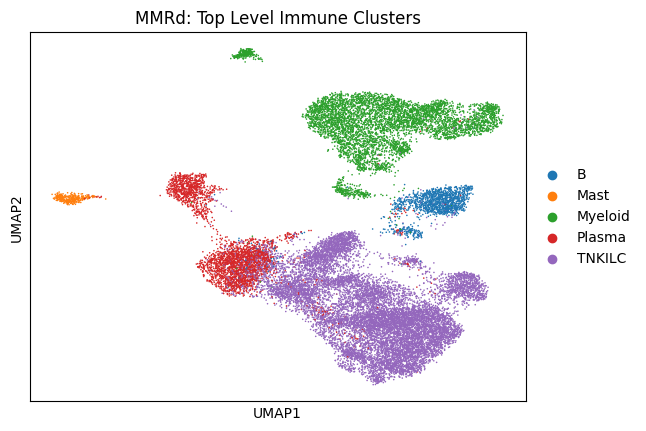

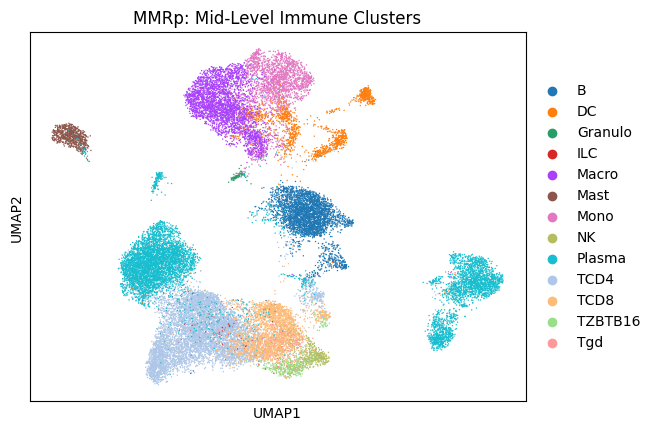

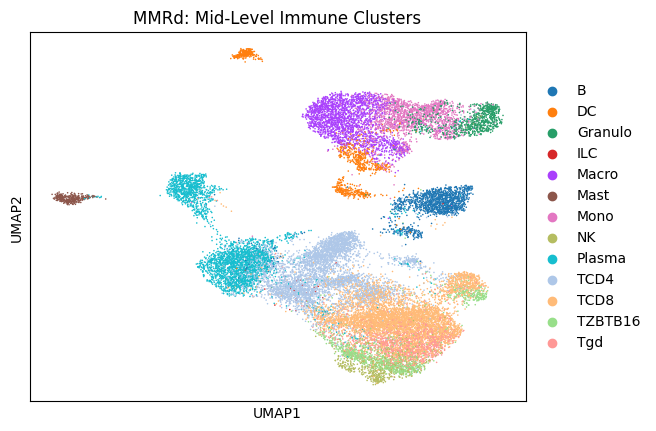

In [37]:
# Plot top-level UMAPs
sc.pl.umap(adata_MMRp, color='clTopLevel', title='MMRp: Top Level Immune Clusters')
sc.pl.umap(adata_MMRd, color='clTopLevel', title='MMRd: Top Level Immune Clusters')

# Plot mid-level UMAPs
sc.pl.umap(adata_MMRp, color='clMidwayPr', title='MMRp: Mid-Level Immune Clusters')
sc.pl.umap(adata_MMRd, color='clMidwayPr', title='MMRd: Mid-Level Immune Clusters')

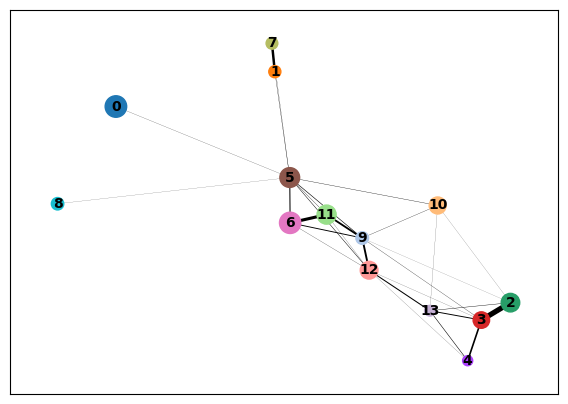

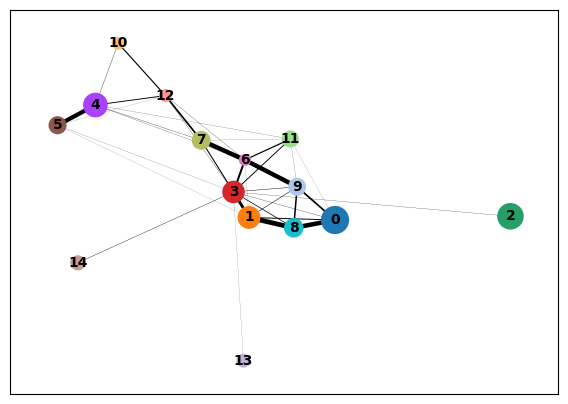

In [ ]:
# Run PAGA for RNA Trajectory Analysis
sc.tl.paga(adata_MMRp, groups='leiden')
sc.tl.paga(adata_MMRd, groups='leiden')

# Plot PAGA Graph
sc.pl.paga(adata_MMRp, color=['leiden'])
sc.pl.paga(adata_MMRd, color=['leiden'])

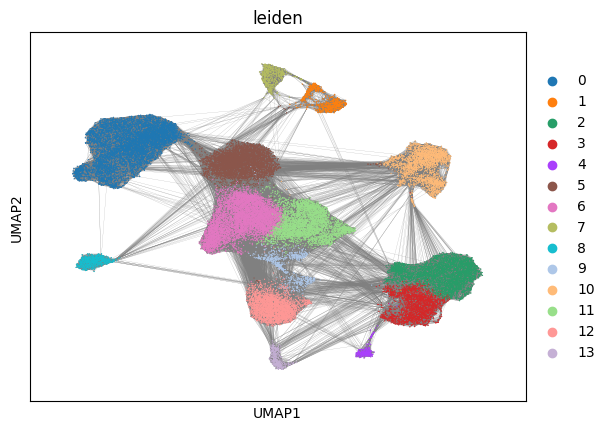

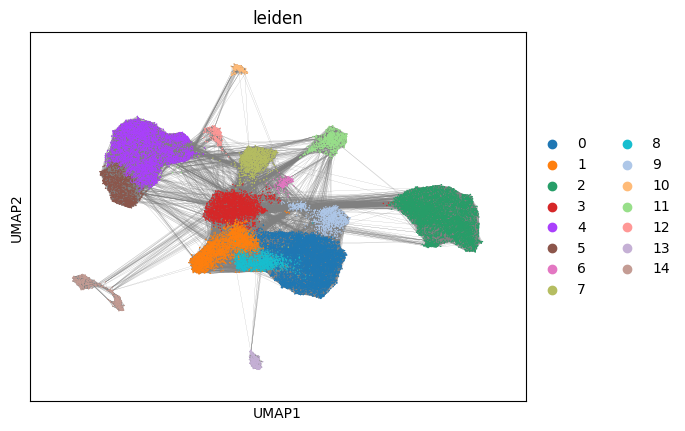

In [15]:
sc.tl.umap(adata_MMRp, init_pos='paga')
sc.tl.umap(adata_MMRd, init_pos='paga')

sc.pl.umap(adata_MMRp, color=['leiden'], edges=True)
sc.pl.umap(adata_MMRd, color=['leiden'], edges=True)

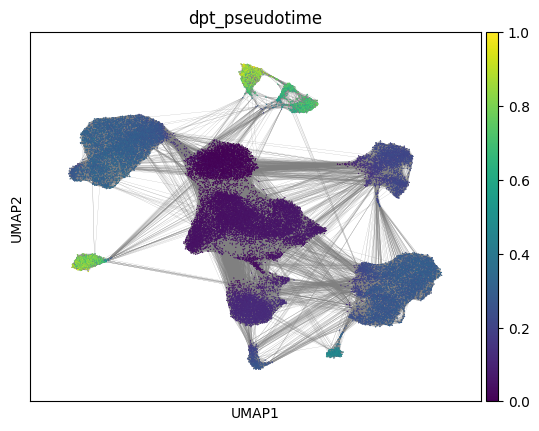

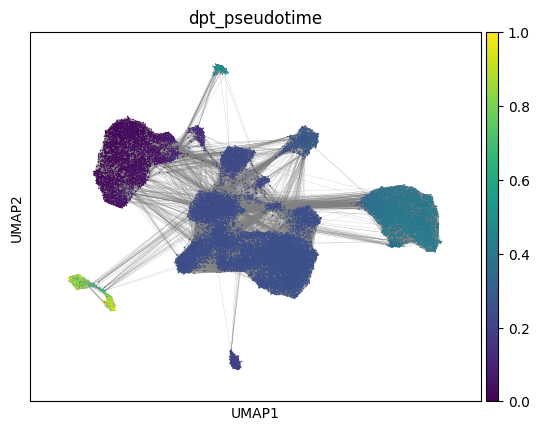

In [16]:
# Pick root cluster number (TODO NEED HELP TO CHOOSE FROM TA)
root_cluster_MMRp = '5'  
# Find a cell index in that cluster to set as root
root_cell_index_MMRp = adata_MMRp.obs.query('leiden == @root_cluster_MMRp').index[0]
# Assign the root cell
adata_MMRp.uns['iroot'] = adata_MMRp.obs_names.get_loc(root_cell_index_MMRp)
# Run Diffusion Pseudotime
sc.tl.dpt(adata_MMRp)
# Create new UMAP
sc.pl.umap(adata_MMRp, color='dpt_pseudotime', edges=True)

# Pick root cluster number (TODO NEED HELP TO CHOOSE FROM TA)
root_cluster_MMRd = '5'  
# Find a cell index in that cluster to set as root
root_cell_index_MMRd = adata_MMRd.obs.query('leiden == @root_cluster_MMRd').index[0]
# Assign the root cell
adata_MMRd.uns['iroot'] = adata_MMRd.obs_names.get_loc(root_cell_index_MMRd)
# Run Diffusion Pseudotime
sc.tl.dpt(adata_MMRd)
# Create new UMAP
sc.pl.umap(adata_MMRd, color='dpt_pseudotime', edges=True)

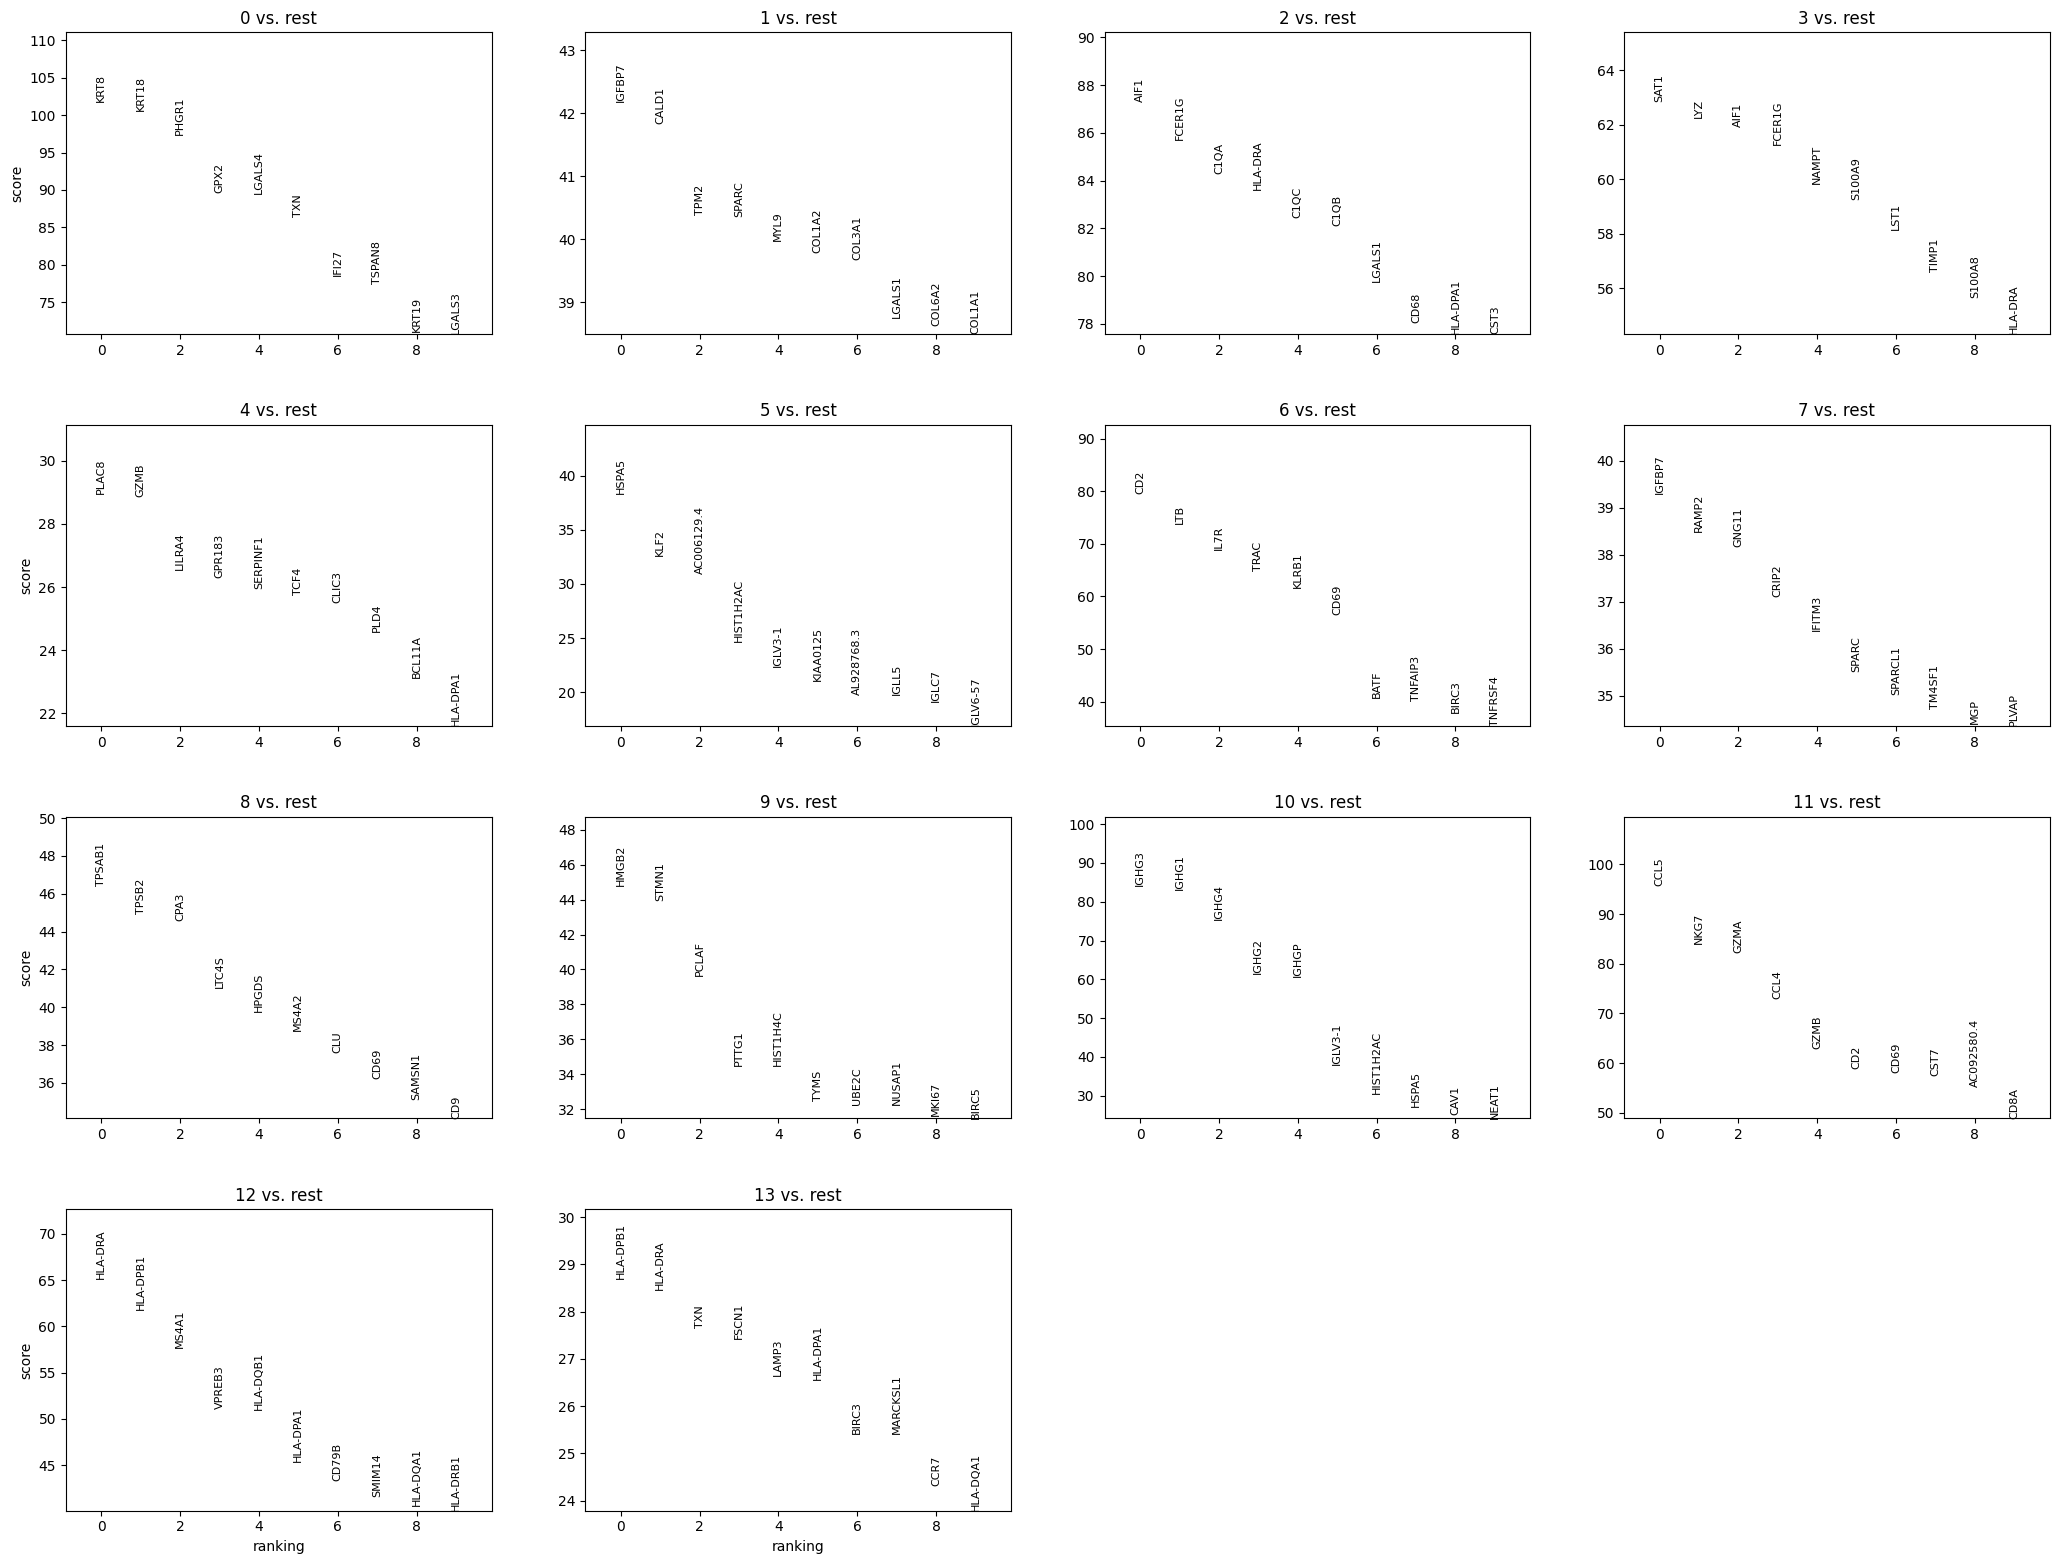

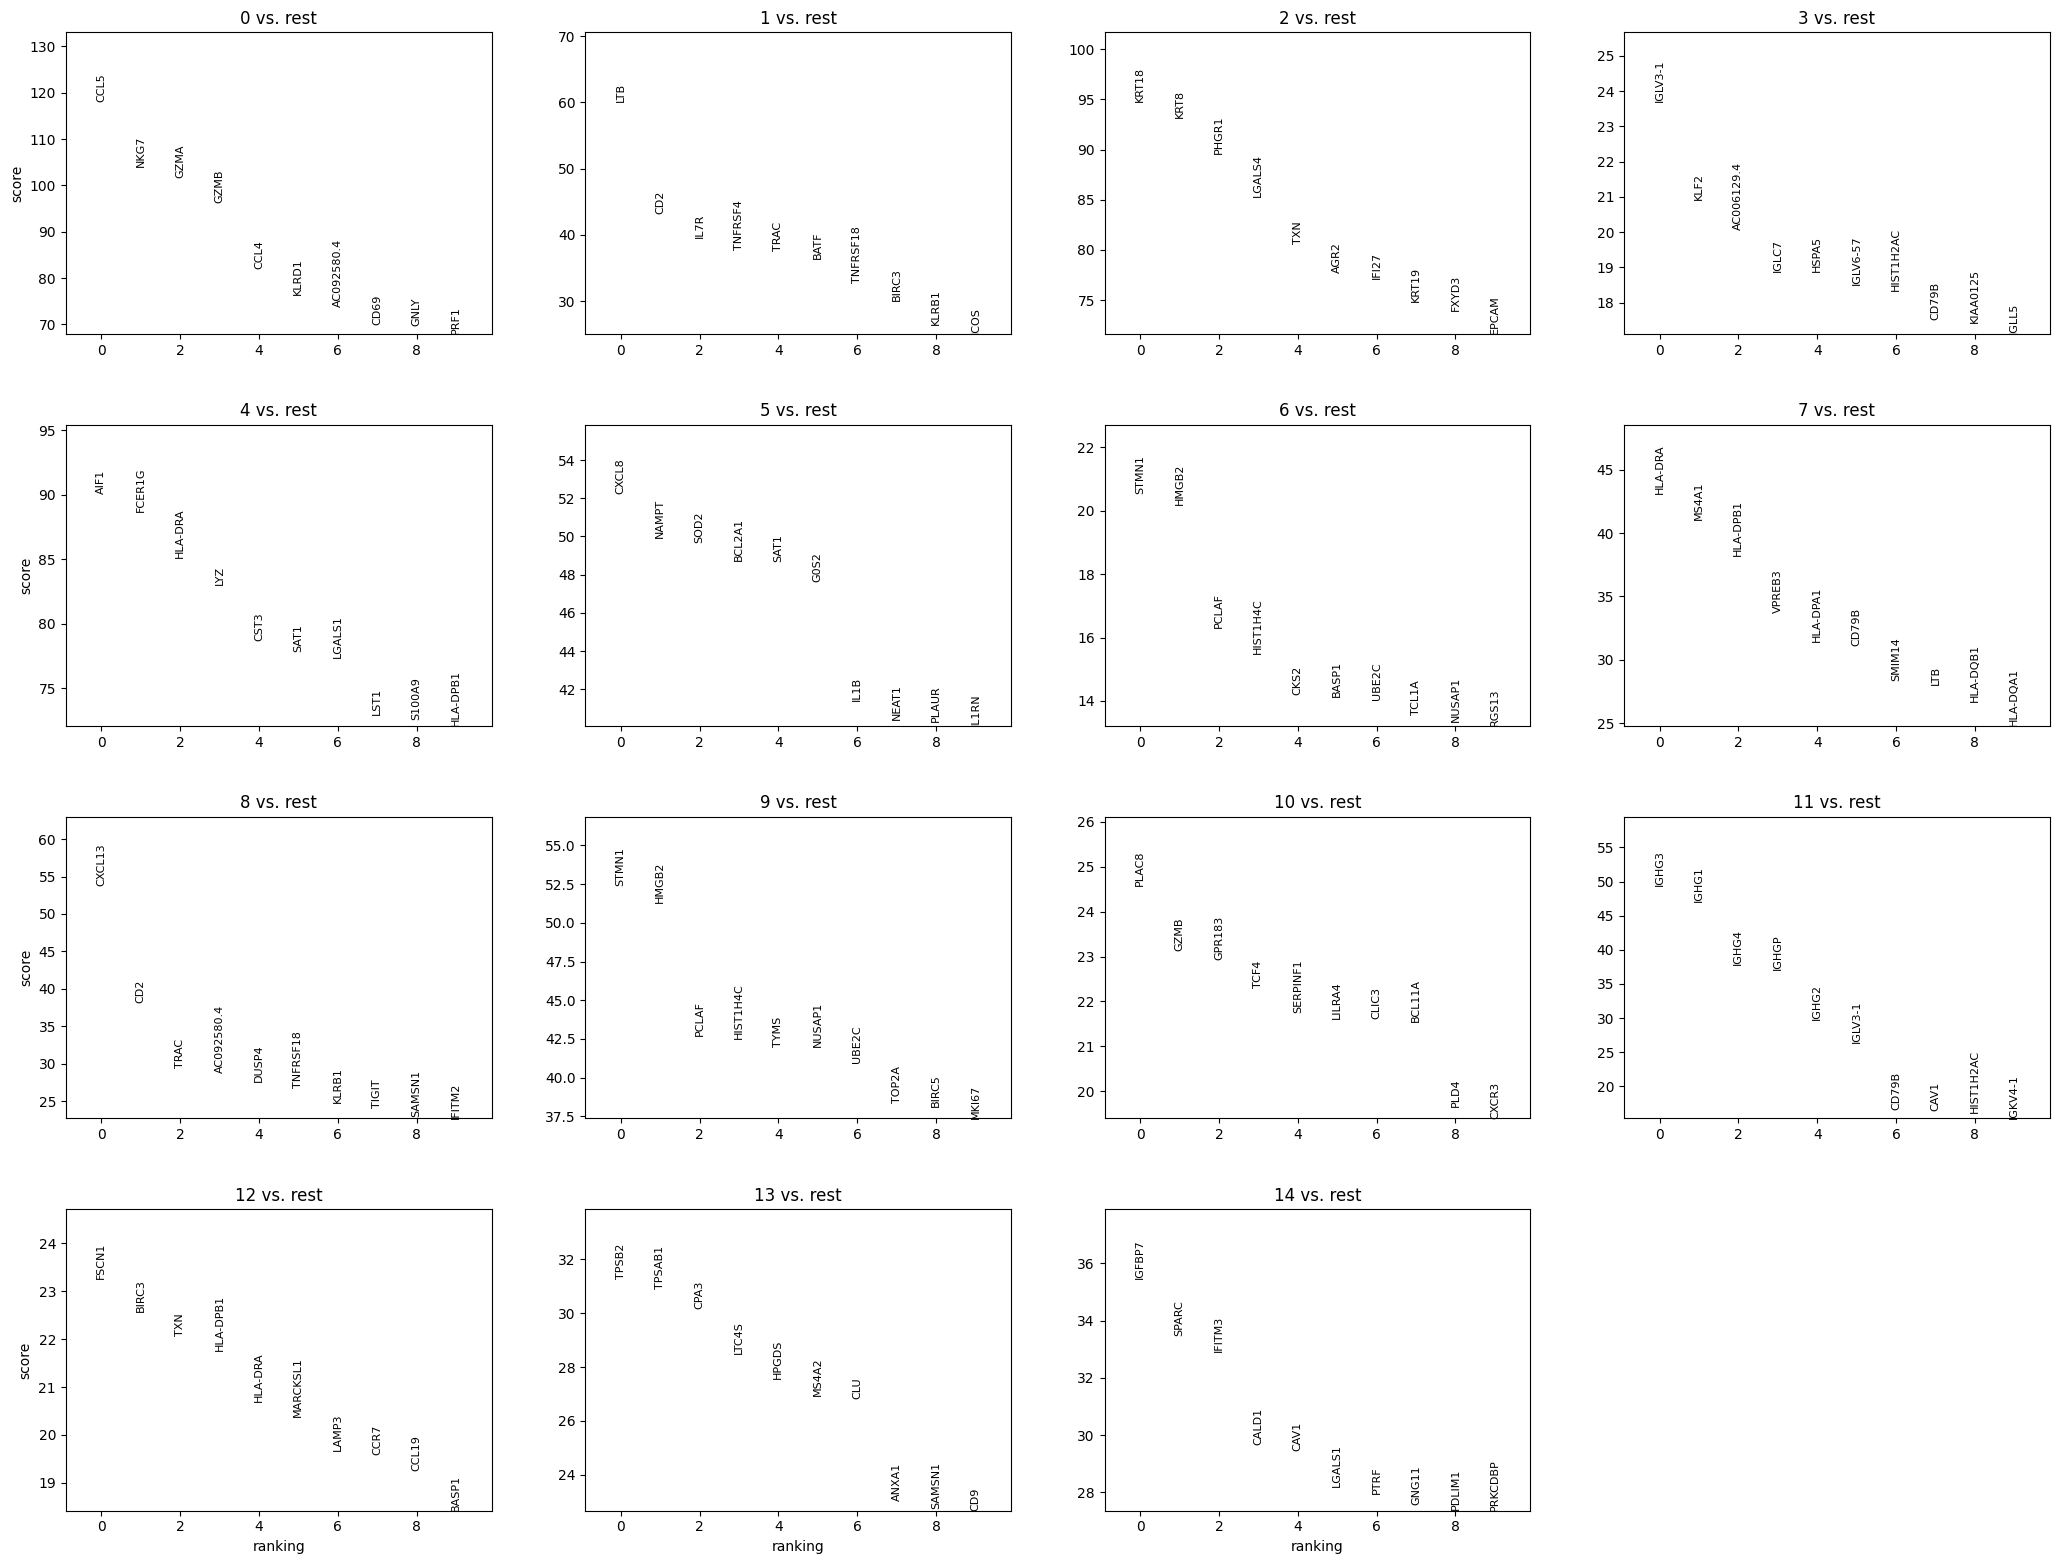

In [17]:
# Find the top-expressed genes in each cluster
sc.tl.rank_genes_groups(adata_MMRp, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_MMRp, n_genes=10, sharey=False)

sc.tl.rank_genes_groups(adata_MMRd, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_MMRd, n_genes=10, sharey=False)